# Imports

In [1]:
from load_dataset import load_dataset
from create_dataloader import create_dataloader
from preprocess import crop_images, gland_type_division
from model import computeAUCs,train_model,createFTNetworkGoogLeNet,test_model

import matplotlib.pyplot as plt
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform, util
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from PIL import Image
import pdb
import random
import numpy.random as npr

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# MODEL TRAINING

## Load data

In [2]:
!pip install openpyxl

In [3]:
file_path = "./Imágenes + Labels"
images_path= file_path
csv_path= file_path+ "/Anonymized images_student.xlsx"
images, image_data = load_dataset(images_path,csv_path)

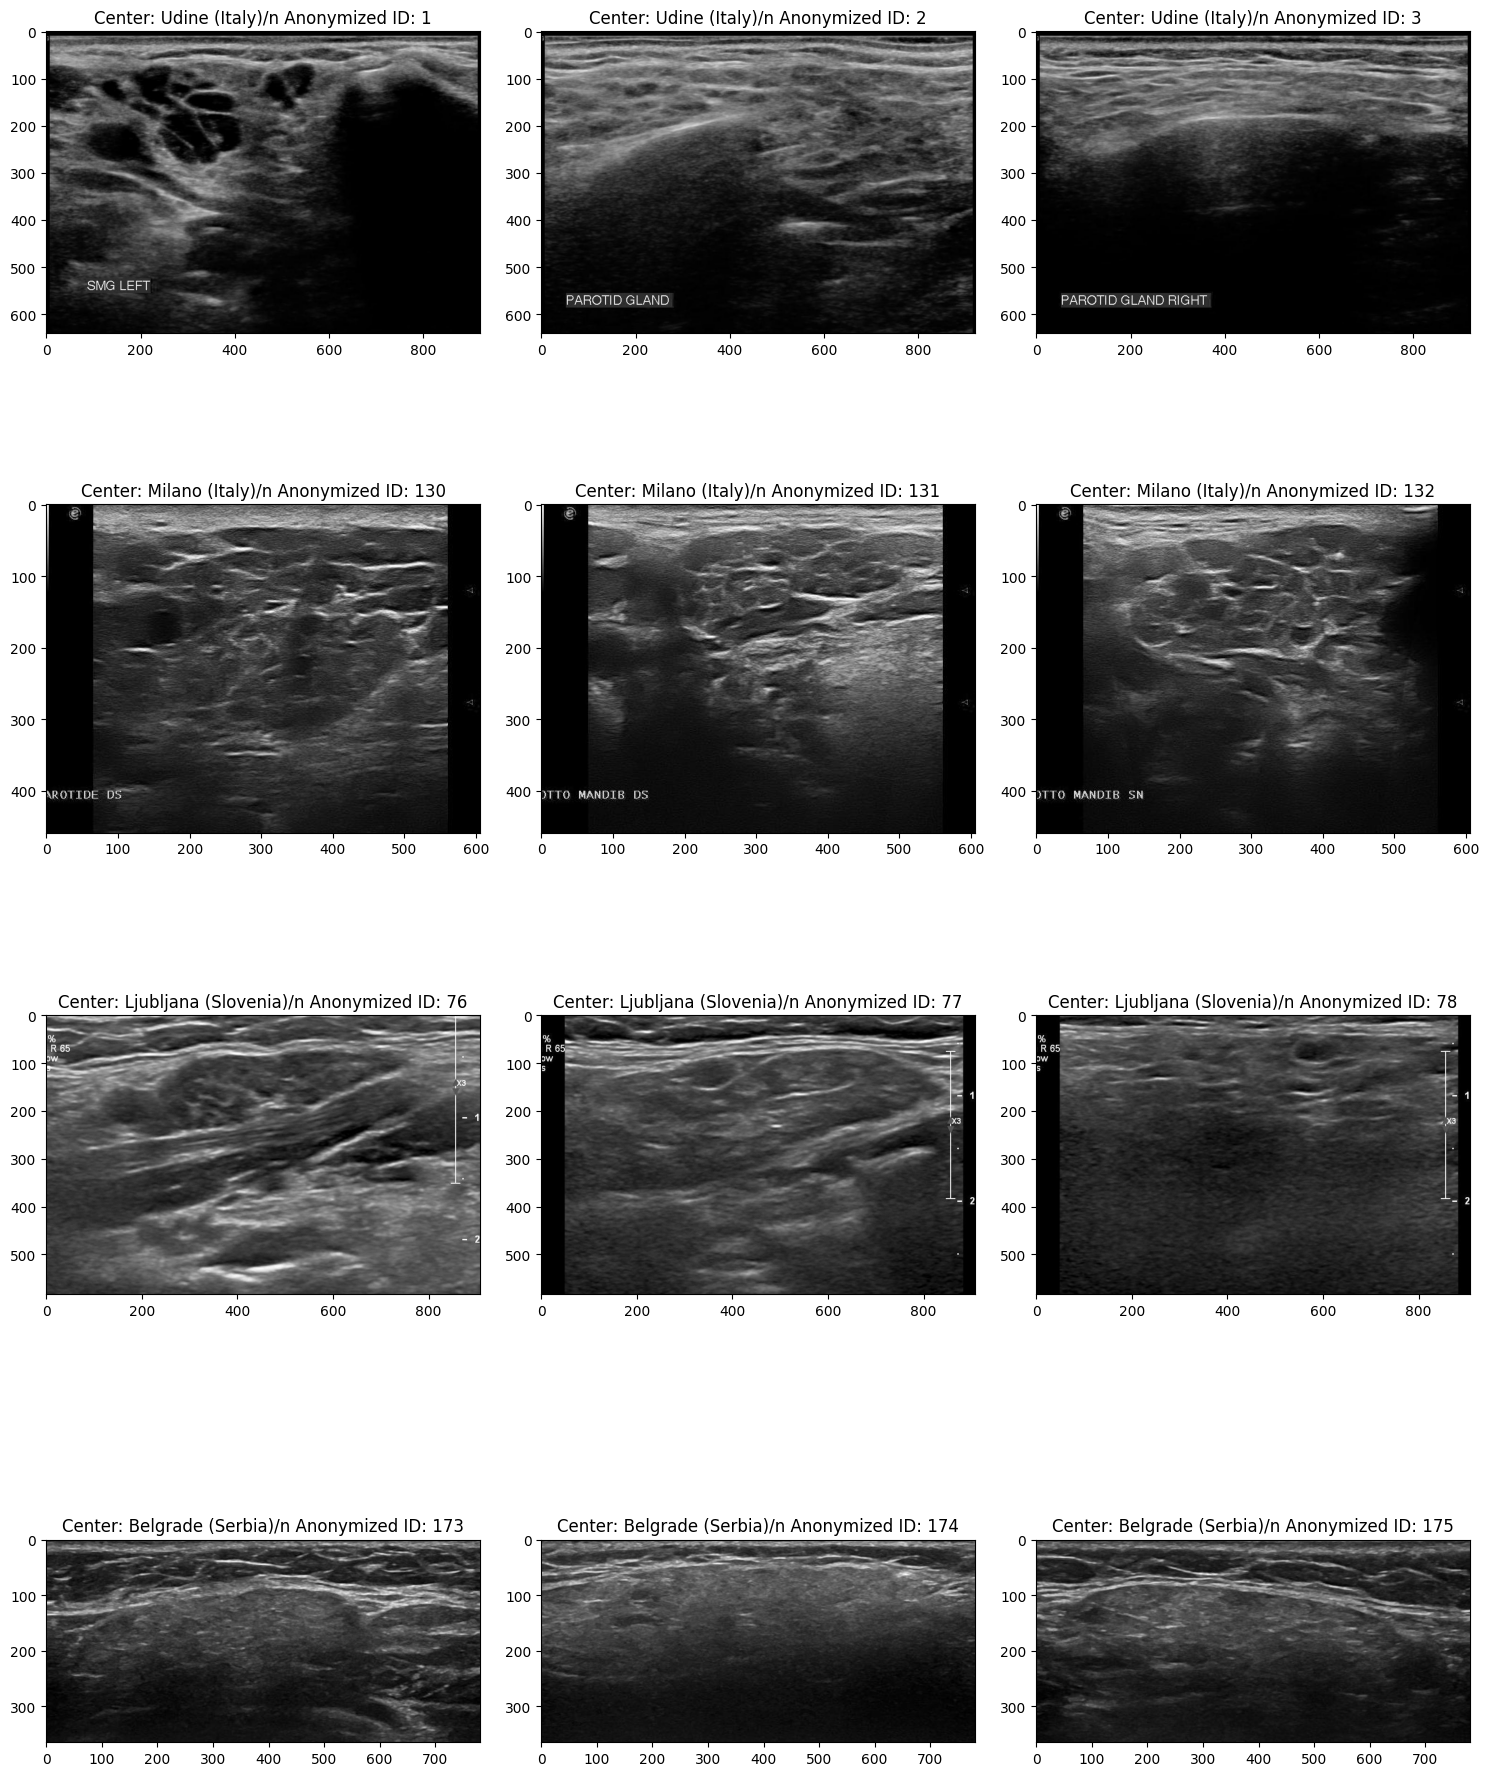

In [4]:
centers=set(image_data['Center'])
fig, axes = plt.subplots(nrows=len(centers), ncols=3, figsize=(15, 5*len(centers)))
for i, center in enumerate(centers):
  image_data_center = image_data[image_data['Center'] == center]

  for j in range(3):
        # Get the image data for the current row
        keys_example = image_data_center.iloc[j]['Anonymized ID']
        im_example=images[keys_example]
        # Plot the image on the corresponding axis
        axes[i, j].imshow(im_example, cmap='gray')
        axes[i, j].set_title(f'Center: {center}/n Anonymized ID: {keys_example}')


plt.tight_layout()
plt.show()

## Crop images

In [5]:
cropped_images = crop_images(images, image_data, x_size=497, y_size=365)

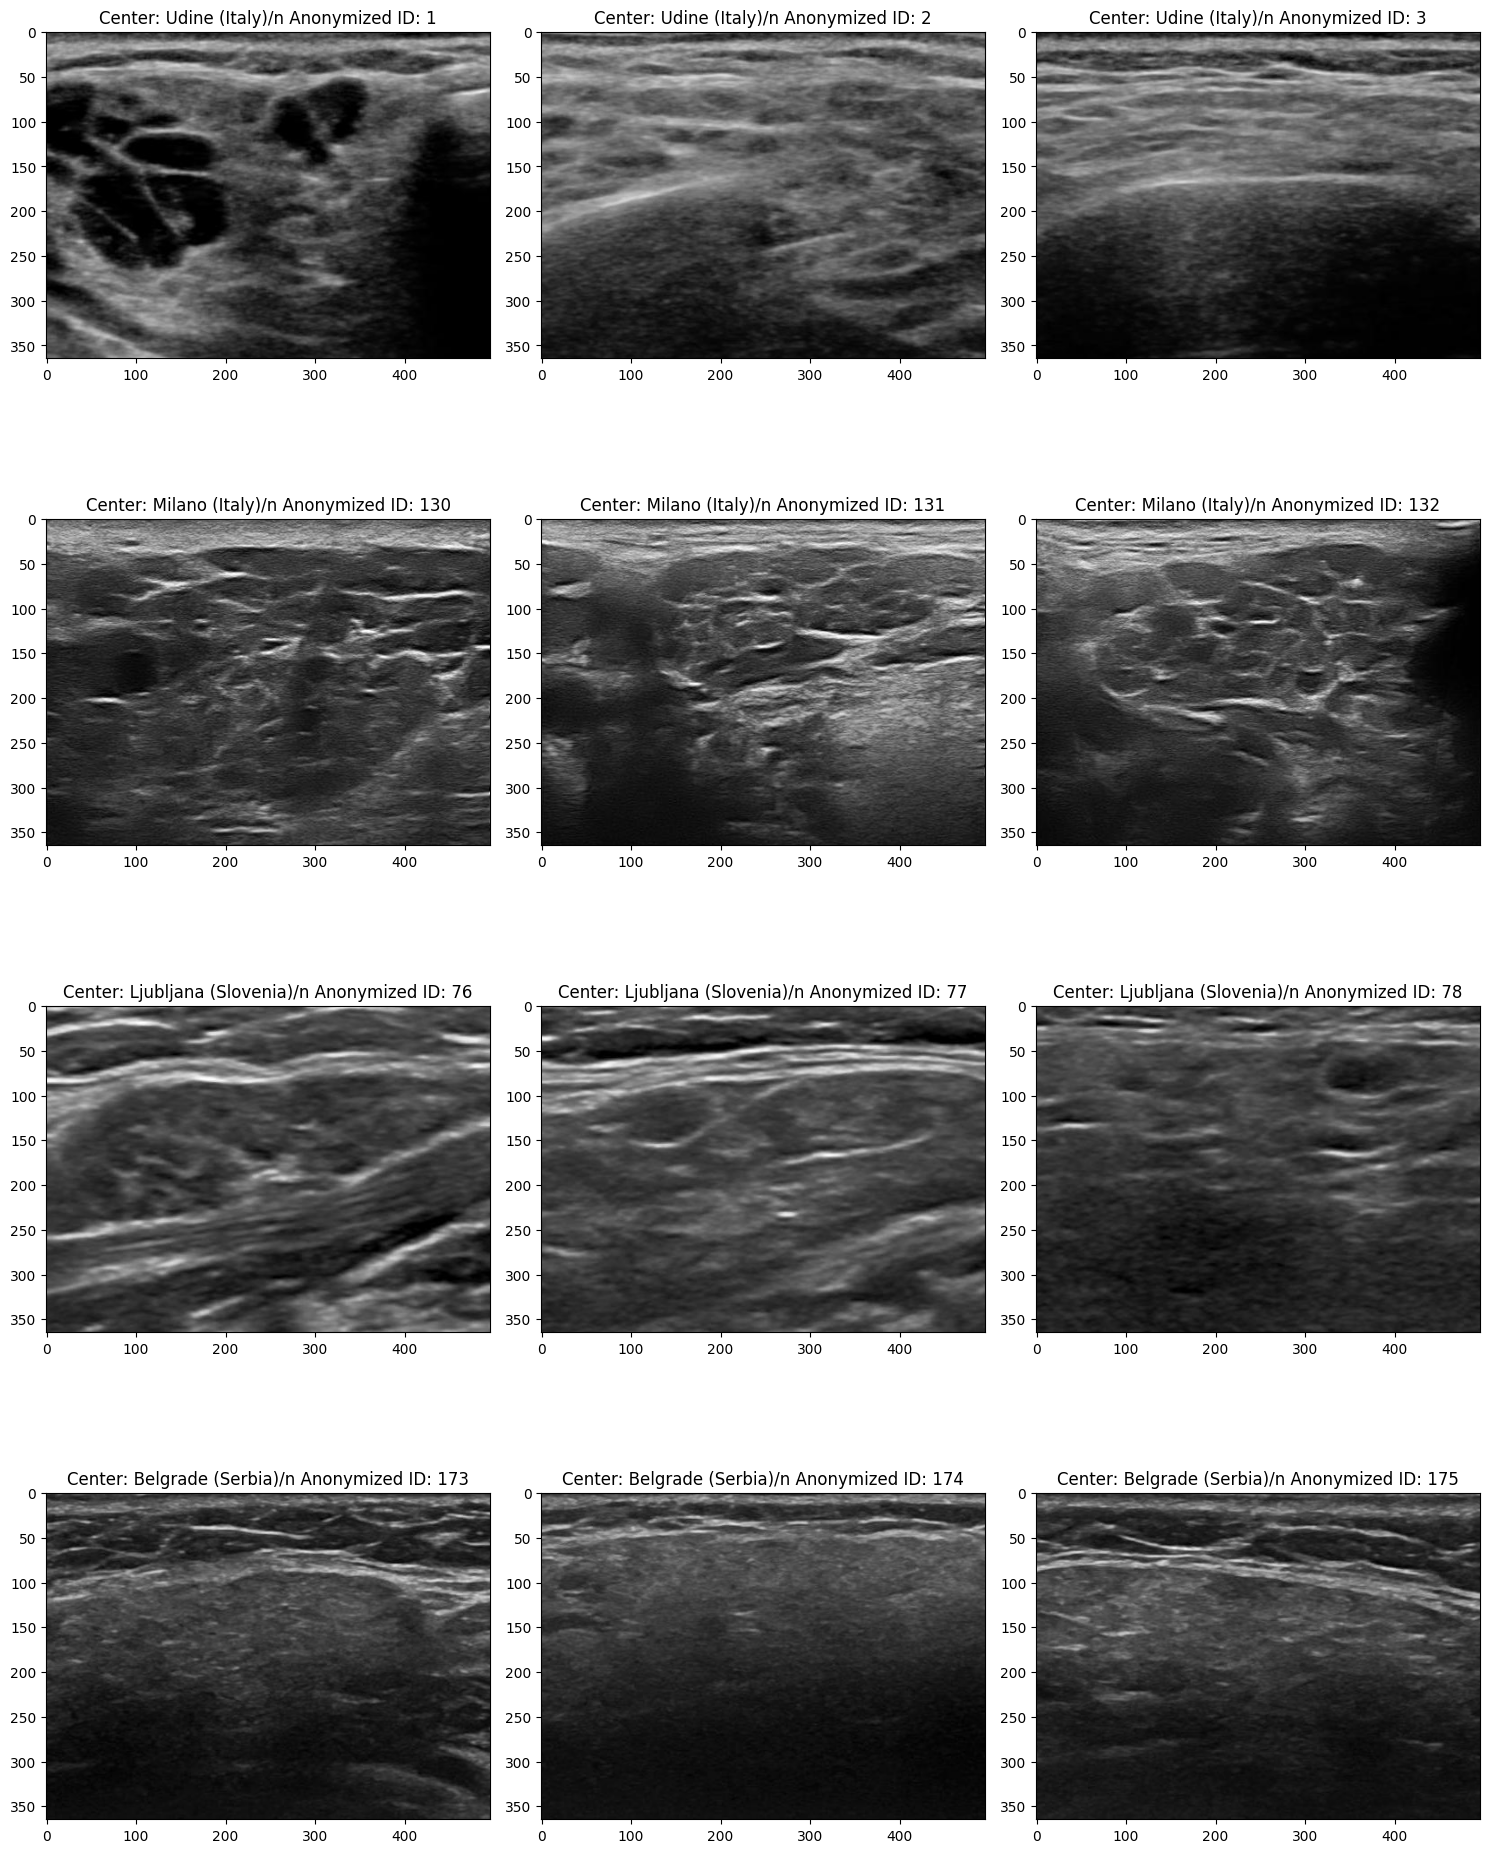

In [6]:
centers=set(image_data['Center'])
fig, axes = plt.subplots(nrows=len(centers), ncols=3, figsize=(15, 5*len(centers)))
for i, center in enumerate(centers):
  image_data_center = image_data[image_data['Center'] == center]

  for j in range(3):
        # Get the image data for the current row
        keys_example = image_data_center.iloc[j]['Anonymized ID']
        im_example=cropped_images[keys_example]
        # Plot the image on the corresponding axis
        axes[i, j].imshow(im_example, cmap='gray')
        axes[i, j].set_title(f'Center: {center}/n Anonymized ID: {keys_example}')


plt.tight_layout()
plt.show()

# Train and val split

In [7]:
from sklearn.model_selection import train_test_split  
groups = image_data.groupby('Patient ID').size().reset_index(name='counts')
train_patient_ids, val_patient_ids = train_test_split(groups['Patient ID'], test_size=0.3, random_state=42)

anonimyzed_ID=image_data['Anonymized ID'].tolist()
anonimyzed_ID_train=[anonimyzed_ID[train_id] for train_id in train_patient_ids]
anonimyzed_ID_val=[anonimyzed_ID[val_id] for val_id in val_patient_ids]

In [8]:
x_train = []
x_val = []
x_train_parotid = []
x_train_subm = []
x_val_parotid = []
x_val_subm = []
y_train = []
y_val = []
y_train_parotid = []
y_train_subm = []
y_val_parotid = []
y_val_subm = []

# Iterate over the DataFrame to populate the lists
for index, row in image_data.iterrows():
    anonymized_id = row['Anonymized ID']
    image = cropped_images.get(anonymized_id)
    omeract_score = row['OMERACT score']
    
    if anonymized_id in anonimyzed_ID_train:
        x_train.append(image)
        y_train.append(omeract_score)
        if row['parotid/submandibular'] == 'parotid':
            x_train_parotid.append(image)
            y_train_parotid.append(omeract_score)
        elif row['parotid/submandibular'] == 'submandibular':
            x_train_subm.append(image)
            y_train_subm.append(omeract_score)
    elif anonymized_id in anonimyzed_ID_val:
        x_val.append(image)
        y_val.append(omeract_score)
        if row['parotid/submandibular'] == 'parotid':
            x_val_parotid.append(image)
            y_val_parotid.append(omeract_score)
        elif row['parotid/submandibular'] == 'submandibular':
            x_val_subm.append(image)
            y_val_subm.append(omeract_score)

## Dataset & dataloader creation

In [9]:

train_dataset, train_loader = create_dataloader(x_train, y_train, batch_size=8, dataloader_type="train", target_size = (365, 496))
train_subm_dataset,train_subm_loader = create_dataloader(x_train_subm, y_train_subm, batch_size=8, dataloader_type="train", target_size = (365, 496))
train_parotid_dataset,train_parotid_loader = create_dataloader(x_train_parotid, y_train_parotid, batch_size=8, dataloader_type="train", target_size = (365, 496))

val_dataset, val_loader = create_dataloader(x_val, y_val, batch_size=8, dataloader_type="val", target_size = (365, 496))
val_subm_dataset,val_subm_loader = create_dataloader(x_val_subm, y_val_subm, batch_size=8, dataloader_type="val", target_size = (365, 496))
val_parotid_dataset,val_parotid_loader = create_dataloader(x_val_parotid, y_val_parotid, batch_size=8, dataloader_type="val", target_size = (365, 496))


In [10]:
image_datasets = {'train' : train_dataset, 'val': val_dataset}
dataloaders = {'train' : train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}


image_datasets_subm = {'train' : train_subm_dataset, 'val': val_subm_dataset}
dataloaders_subm = {'train' : train_subm_loader, 'val': val_subm_loader}
dataset_sizes_subm = {'train': len(train_subm_dataset), 'val': len(val_subm_dataset)}


image_datasets_parotid = {'train' : train_dataset, 'val': val_dataset}
dataloaders_parotid = {'train' : train_parotid_loader, 'val': val_parotid_loader}
dataset_sizes_parotid = {'train': len(train_parotid_dataset), 'val': len(val_parotid_dataset)}

## Pretrained model fine tuning: Google LeNET

### Fine tunining for submadibular and parotid glands together

In [11]:
ftNet = createFTNetworkGoogLeNet()
ftNet = ftNet.to(device)

In [12]:

os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
random.seed(42)
npr.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.benchmark = False

#Create the network and pass to the GPU
ftNet = createFTNetworkGoogLeNet()
ftNet = ftNet.to(device)

#Loss function
criterion = nn.CrossEntropyLoss()

#ADAM optimizer
optimizer_ft = optim.Adam(ftNet.parameters(),lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=100000, gamma=0.1)


ftNet = train_model(dataloaders, dataset_sizes, ftNet, criterion, optimizer_ft, exp_lr_scheduler, device, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3253 AUC OMERACT 0: 0.5503 OMERACT 1: 0.3757 OMERACT 2: 0.5572 OMERACT 3: 0.7745 avg: 0.5644
val Loss: 1.3823 AUC OMERACT 0: 0.3854 OMERACT 1: 0.2308 OMERACT 2: 0.3646 OMERACT 3: 0.5167 avg: 0.3744

Epoch 1/24
----------
train Loss: 1.1592 AUC OMERACT 0: 0.7799 OMERACT 1: 0.6497 OMERACT 2: 0.5875 OMERACT 3: 0.8137 avg: 0.7077
val Loss: 1.2543 AUC OMERACT 0: 0.6771 OMERACT 1: 0.3846 OMERACT 2: 0.5729 OMERACT 3: 0.8333 avg: 0.6170

Epoch 2/24
----------
train Loss: 1.0222 AUC OMERACT 0: 0.8748 OMERACT 1: 0.7119 OMERACT 2: 0.8199 OMERACT 3: 0.8319 avg: 0.8096
val Loss: 1.1122 AUC OMERACT 0: 0.9010 OMERACT 1: 0.5577 OMERACT 2: 0.8021 OMERACT 3: 0.9000 avg: 0.7902

Epoch 3/24
----------
train Loss: 0.9305 AUC OMERACT 0: 0.9080 OMERACT 1: 0.7599 OMERACT 2: 0.8687 OMERACT 3: 0.8123 avg: 0.8372
val Loss: 0.9485 AUC OMERACT 0: 0.8698 OMERACT 1: 0.6346 OMERACT 2: 0.7708 OMERACT 3: 0.9389 avg: 0.8035

Epoch 4/24
----------
train Loss: 0.8505 AUC OMERACT 0: 0.93

In [13]:
torch.save(ftNet.state_dict(), "model_weights_general")

#### Fine tuning the previous model for submandibular glands

In [14]:
ftNet_general_submandibular = train_model(dataloaders_subm, dataset_sizes_subm, ftNet, criterion, optimizer_ft, exp_lr_scheduler, device, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.6052 AUC OMERACT 0: 0.9083 OMERACT 1: 1.0000 OMERACT 2: 1.0000 OMERACT 3: 0.7391 avg: 0.9119
val Loss: 0.4781 AUC OMERACT 0: 0.9429 OMERACT 1: 1.0000 OMERACT 2: 1.0000 OMERACT 3: 1.0000 avg: 0.9857

Epoch 1/49
----------
train Loss: 0.6294 AUC OMERACT 0: 0.8500 OMERACT 1: 0.7083 OMERACT 2: 1.0000 OMERACT 3: 0.9710 avg: 0.8823
val Loss: 0.5832 AUC OMERACT 0: 0.9429 OMERACT 1: 1.0000 OMERACT 2: 0.8182 OMERACT 3: 1.0000 avg: 0.9403

Epoch 2/49
----------
train Loss: 0.4174 AUC OMERACT 0: 1.0000 OMERACT 1: 1.0000 OMERACT 2: 1.0000 OMERACT 3: 1.0000 avg: 1.0000
val Loss: 0.6452 AUC OMERACT 0: 0.9143 OMERACT 1: 1.0000 OMERACT 2: 0.7273 OMERACT 3: 1.0000 avg: 0.9104

Epoch 3/49
----------
train Loss: 0.3891 AUC OMERACT 0: 1.0000 OMERACT 1: 1.0000 OMERACT 2: 1.0000 OMERACT 3: 1.0000 avg: 1.0000
val Loss: 0.6207 AUC OMERACT 0: 0.9143 OMERACT 1: 1.0000 OMERACT 2: 0.7273 OMERACT 3: 1.0000 avg: 0.9104

Epoch 4/49
----------
train Loss: 0.3498 AUC OMERACT 0: 1.00

In [15]:
torch.save(ftNet_general_submandibular.state_dict(), "model_weights_submandibular")

#### Fine tuning the previous model for only parotid glands

In [16]:
ftNet_general_parotid = train_model(dataloaders_parotid, dataset_sizes_parotid, ftNet, criterion, optimizer_ft, exp_lr_scheduler, device, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.6120 AUC OMERACT 0: 0.9943 OMERACT 1: 0.9714 OMERACT 2: 0.9828 OMERACT 3: 0.8669 avg: 0.9538
val Loss: 0.8199 AUC OMERACT 0: 0.9091 OMERACT 1: 0.7333 OMERACT 2: 0.6923 OMERACT 3: 0.9841 avg: 0.8297

Epoch 1/49
----------
train Loss: 0.3298 AUC OMERACT 0: 1.0000 OMERACT 1: 1.0000 OMERACT 2: 1.0000 OMERACT 3: 0.9968 avg: 0.9992
val Loss: 0.8969 AUC OMERACT 0: 0.8909 OMERACT 1: 0.8667 OMERACT 2: 0.6923 OMERACT 3: 0.9841 avg: 0.8585

Epoch 2/49
----------
train Loss: 0.4121 AUC OMERACT 0: 0.9857 OMERACT 1: 0.8643 OMERACT 2: 0.9828 OMERACT 3: 1.0000 avg: 0.9582
val Loss: 0.8156 AUC OMERACT 0: 0.9091 OMERACT 1: 0.9333 OMERACT 2: 0.6923 OMERACT 3: 0.9841 avg: 0.8797

Epoch 3/49
----------
train Loss: 0.5507 AUC OMERACT 0: 0.9429 OMERACT 1: 0.8929 OMERACT 2: 0.9000 OMERACT 3: 0.9935 avg: 0.9323
val Loss: 0.8871 AUC OMERACT 0: 0.8909 OMERACT 1: 0.8667 OMERACT 2: 0.6923 OMERACT 3: 0.9841 avg: 0.8585

Epoch 4/49
----------
train Loss: 0.3336 AUC OMERACT 0: 1.00

In [17]:
torch.save(ftNet_general_parotid.state_dict(), "model_weights_parotid")

# MODEL EVALUATION

This section returns the soft outputs of the predictions divided in two groups for the parotid and submandibular glands, respectively

In [ ]:
test_images_path = #Fill with the test image file path 
test_xlsx_path= #Fill with the xlsx iamge file path 
test_images, test_image_data = load_dataset(test_images_path,test_xlsx_path)

In [ ]:
cropped_images_test = crop_images(test_images, test_image_data, x_size=497, y_size=365)

In [ ]:
submandibular_images, submandibular_labels, parotid_images, parotid_labels = gland_type_division(cropped_images_test,test_image_data)

In [ ]:

test_subm_dataset,test_subm_loader = create_dataloader(submandibular_images, submandibular_labels, batch_size=8, dataloader_type="test", target_size = (365, 496))
test_parotid_dataset,test_parotid_loader = create_dataloader(parotid_images, parotid_labels, batch_size=8, dataloader_type="test", target_size = (365, 496))

In [ ]:
dict_subm=torch.load("model_weights_submandibular")
model_subm=createFTNetworkGoogLeNet()
model_subm.load_state_dict(dict_subm)
soft_outputs_subm=test_model(model_subm, test_subm_dataset, test_subm_loader, device)

In [ ]:
dict_parotid=torch.load("model_weights_parotid")
model_parotid=createFTNetworkGoogLeNet()
dict_parotid.load_state_dict(dict_parotid)
soft_outputs_parotid=test_model(model_parotid, test_parotid_dataset, test_parotid_loader, device)